# MRI QA Summary Reports

In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from mriqa.dcmio import fetch_series
from mriqa.reports import ghosting_report, slice_profile_report, distortion_report, resolution_bars_report, uniformity_report

In [ ]:
patid = 'PQABHV20151001'
stuid = '1'

## Slice Profile

The TO2 phantom has two crossed plates and two pairs of wedges. Here we use the two crossed plates to estimate the full-width half maximum of the slice profile for 5mm and 3mm slices as described in the IPEM *green book*.

To go from the width of the profile in the image we need to scale by the tangent of the plate angle which here we take to be 11.7 degrees.

To facilitate the analysis we interpolate the images to higher resolution first. Having extracted the thick profiles we fit a quadratic bias the the start and end of the profile assuming this is outside of the plate and is just the gain field for the background liquid in the phantom. We divide the profiles by this modelled gain variation and also invert them to give a positive going *line shape*.

This is fitted using cubic splines and the half height position found to determine the FWHM which is then scaled appropriately for pixel size and plate projection.

Although we correct for it below, it is better to use prescan normalised images to limit the bias in the background field.

### 3 mm

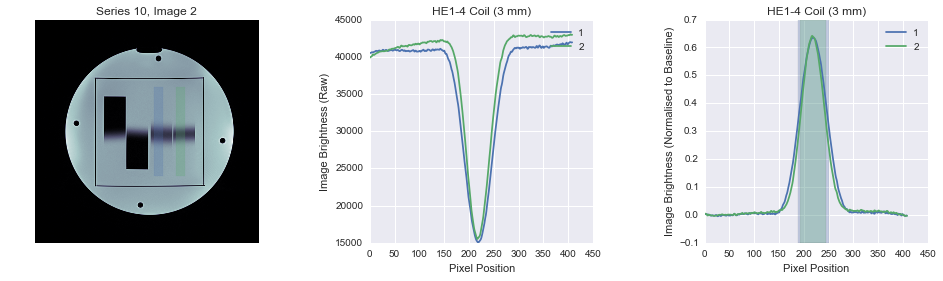

FWHM     (1) =  63.0 pixels, or 3.2 mm
FWHM     (2) =  53.8 pixels, or 2.7 mm
FWHM (GMEAN) =  58.2 pixels, or 2.9 mm


In [2]:
# TO2: Slice 3mm
patid = 'PQA20150331RHD'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[10])
slice_idx = 1
results = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

### 5 mm

In [3]:
# TO2: Slice 5mm
patid = 'PQA20150331RHD'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[6])
slice_idx = 1
result = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)
results = results.append(result)

FWHM     (1) =  97.6 pixels, or 4.9 mm
FWHM     (2) =  84.9 pixels, or 4.3 mm
FWHM (GMEAN) =  91.0 pixels, or 4.6 mm


In [4]:
results[['FWHMGMeanPixels', 'FWHMGMeanMM']]

FWHMGMeanPixels  FWHMGMeanMM
SliceThickness                              
3                     58.205433     2.942814
5                     91.028080     4.602297

## Geometric Distortion and Scaling

The TO2 phantom has a 120mm square box for distortion measurements. Here we use this to estimate the in plane scale (aka *linearity*) and the relative distortion as described in the IPEM Report 80 *green book*. It is best to use the 3mm slice series for this and we choose a slice in the middle of the block.

If scans are available at 512x512 rather than 256x256 this allows more accurate determination of the distortion but note that the bandwidth should be scaled down by a factor to to obtain the same sensitivity to off-resonance distortion. The scans should be acquire with the phase encoding direction both along columns and along rows to separate off-resonance effects from gradient spatial non-linearity.

After centring the phantom we extract an ROI for the box using its expected position in the phantom. The central area is occupied by the wedges and plates so we fill this with the phantom background intensity so it doesn't interfere with profiles across the ROI.

Then, to get smoother and more easily locatable peaks in the profiles we interpolate the image to higher resolution using the `scipy.ndimage` image `zoom` function. 

In [5]:
# TO2: Distortion
# SE: Axial, Phase RL, 512
patid = 'PQA20150331RHD'
stuid = '1'
dobjs = fetch_series(patid, stuid, sernos=[8])

slice_idx = len(dobjs)//2
results = distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

Horizontal Distances:     [120.60546875, 120.849609375, 120.7275390625] (mm)
Scale (Horizontal):       120.7 mm
Distortion (Horizontal):  0.08 %
Vertical Distances:       [120.361328125, 120.361328125, 120.361328125] (mm)
Scale (Vertical):         120.4 mm
Distortion (Vertical):    0.00 %


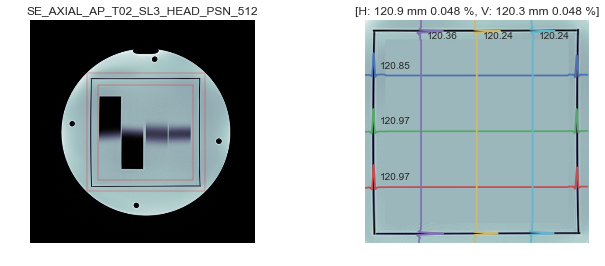

Horizontal Distances:     [120.849609375, 120.9716796875, 120.9716796875] (mm)
Scale (Horizontal):       120.9 mm
Distortion (Horizontal):  0.05 %
Vertical Distances:       [120.361328125, 120.2392578125, 120.2392578125] (mm)
Scale (Vertical):         120.3 mm
Distortion (Vertical):    0.05 %


Orientation PhaseDirection  Sensitivity  HorizontalScale  \
Series                                                            
8            Axial             RL     0.462965       120.727539   
12           Axial             AP     0.462965       120.930990   

        HorizontalDistortion  VerticalScale  VerticalDistortion  
Series                                                           
8                   0.082558     120.361328            0.000000  
12                  0.047585     120.279948            0.047842

In [6]:
# TO2: Distortion
# SE: Axial, Phase AP, 512
patid = 'PQA20150331RHD'
stuid = '1'
dobjs = fetch_series(patid, stuid, sernos=[12])

slice_idx = len(dobjs)//2
results = results.append(distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False))
results[['Orientation', 'PhaseDirection', 'Sensitivity', 'HorizontalScale', 'HorizontalDistortion','VerticalScale', 'VerticalDistortion' ]]

## Spatial Resolution

In [7]:
# TO4: Resolution
patid = 'PQA20140807SC'
stuid = '3'

dobjs = fetch_series(patid, stuid, sernos=[85])
slice_idx = 0
result = resolution_bars_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=True)

## Ghosting

### Spin Echo

In [8]:
# GE10CM: Ghosting
patid = 'PQA20150309CRIC'
stuid = '1'
# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [14, 16]]
results = ghosting_report(dobjs)

### Fast Spin Echo

In [9]:
# GE10CM: Ghosting
# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [18, 20]]
results = results.append(ghosting_report(dobjs))

### EPI

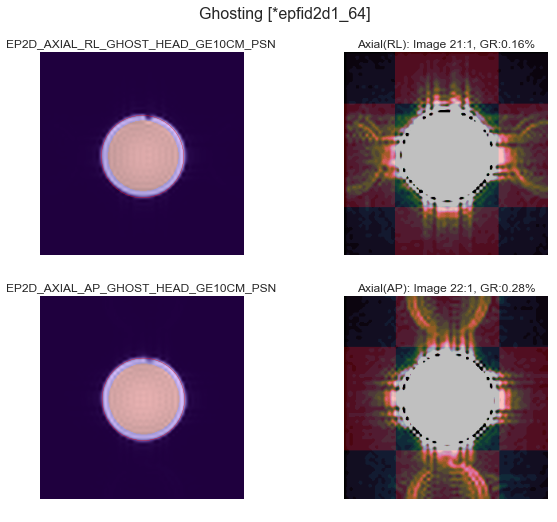

In [10]:
# GE10CM: Ghosting
# EPIFID64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [21, 22]]
results = results.append(ghosting_report(dobjs))

### Spin Echo EPI

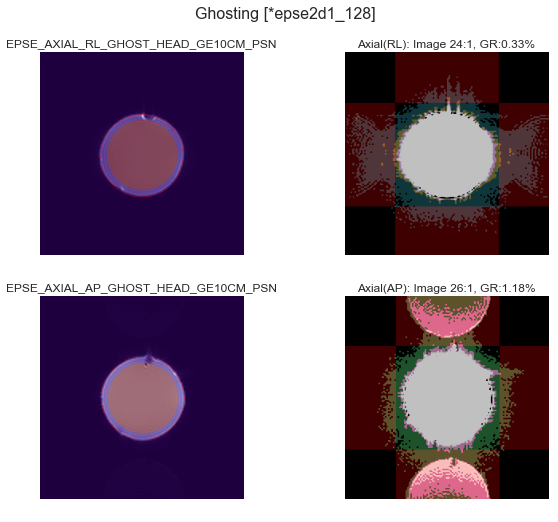

In [11]:
# GE10CM: Ghosting
# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [24, 26]]
results = results.append(ghosting_report(dobjs))

In [12]:
display(results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']])

Sequence Orientation PhaseDirection  GhostRatio
Series                                                     
14            *se2d1       Axial             RL    0.020276
16            *se2d1       Axial             AP    0.052935
18        *tse2d1_18       Axial             RL    0.113645
20        *tse2d1_18       Axial             AP    0.156298
21      *epfid2d1_64       Axial             RL    0.163238
22      *epfid2d1_64       Axial             AP    0.276739
24      *epse2d1_128       Axial             RL    0.326074
26      *epse2d1_128       Axial             AP    1.179879

## Receiver Coil Uniformity

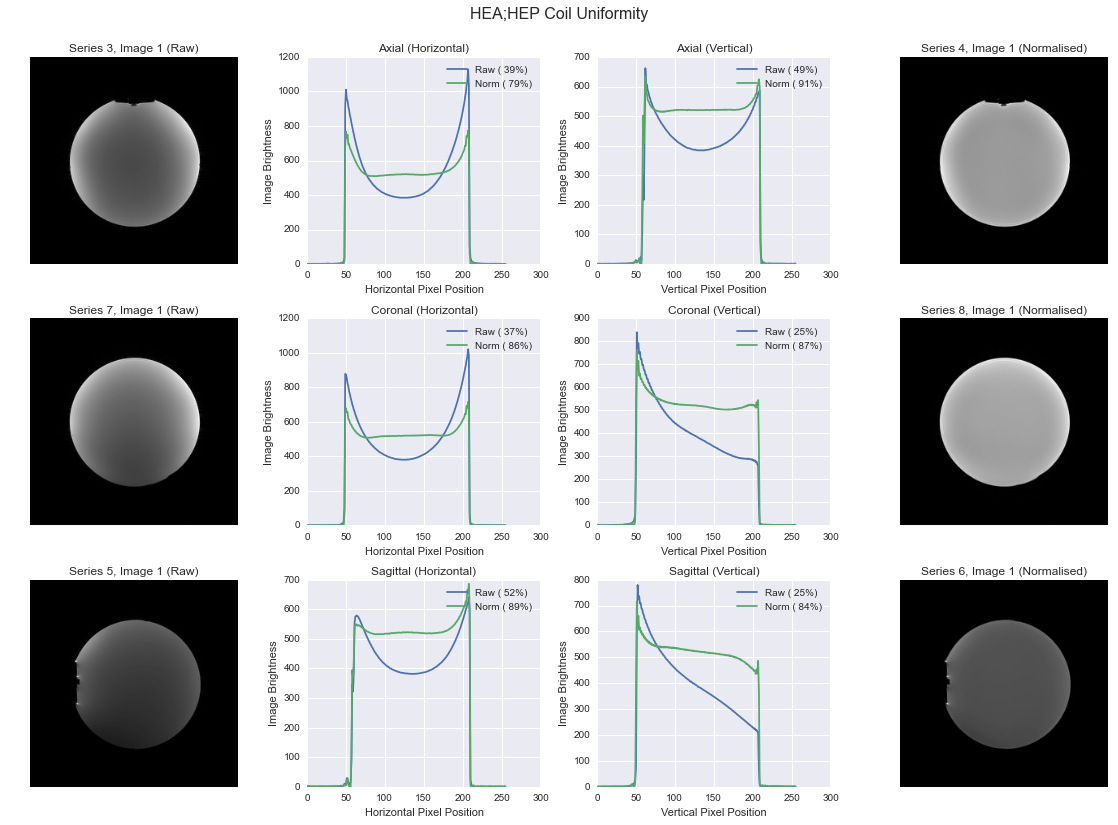

Raw Images


SeriesRaw                                 ProtocolRaw    OrientRaw  \
Axial             3  SE_AXIAL_RL_SNR_UNIF_HEAD_OIL20CM_PSN_NORM     Axial/RL   
Coronal           7    SE_COR_FH_SNR_UNIF_HEAD_OIL20CM_PSN_NORM   Coronal/HF   
Sagittal          5    SE_SAG_AP_SNR_UNIF_HEAD_OIL20CM_PSN_NORM  Sagittal/AP   

          XUniformityRaw  YUniformityRaw  
Axial          38.509317       49.342105  
Coronal        37.267081       25.316456  
Sagittal       51.973684       24.840764

Intensity Normalised Images


SeriesNorm                                ProtocolNorm   OrientNorm  \
Axial              4  SE_AXIAL_RL_SNR_UNIF_HEAD_OIL20CM_PSN_NORM     Axial/RL   
Coronal            8    SE_COR_FH_SNR_UNIF_HEAD_OIL20CM_PSN_NORM   Coronal/HF   
Sagittal           6    SE_SAG_AP_SNR_UNIF_HEAD_OIL20CM_PSN_NORM  Sagittal/AP   

          XUniformityNorm  YUniformityNorm  
Axial           78.750000        91.447368  
Coronal         86.250000        86.792453  
Sagittal        88.815789        84.276730

In [13]:
# OILSPHERE: Unifirmity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
patid = 'PQA20150309CRIC'
stuid = '1'

raw_tra = fetch_series(patid, stuid, sernos=[3])
psn_tra = fetch_series(patid, stuid, sernos=[4])
raw_sag = fetch_series(patid, stuid, sernos=[5])
psn_sag = fetch_series(patid, stuid, sernos=[6])
raw_cor = fetch_series(patid, stuid, sernos=[7])
psn_cor = fetch_series(patid, stuid, sernos=[8])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

print('Raw Images')
display(results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']])
print('Intensity Normalised Images')
display(results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']])